# PhishEye

# Dataset Exploration

In [61]:
import pandas as pd
import dnstwist
import numpy as np 
import matplotlib.pyplot as plt 


In [188]:
fuzz = dnstwist.Fuzzer("www.google.com")
fuzz.generate()
len(fuzz.permutations())

2158

In [189]:
data = dnstwist.run(domain='google.com', registered=True, format='null')
reg = [d['domain'] for d in data]


In [190]:
data_non = dnstwist.run(domain='google.com', unregistered=True, format='null')
nonreg = [d['domain'] for d in data_non]


In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

intersection(reg, nonreg)

In [ ]:
print (f'The number of registered permutations is: {len(reg)}')
print (f'The number of non registered permutations is: {len(nonreg)}')


In [ ]:
print (reg[::15])
print (nonreg[::150])

In [ ]:
domains_df = pd.read_csv('./top-1m.csv', header=None, index_col=0)
domains_df.head()

In [ ]:
def get_dicts(domain_list):
    reg_dict, nonreg_dict = {}, {}
    for domain in domain_list:
        data_reg = dnstwist.run(domain=f'{domain}', registered=True, format='null')
        reg = [d['domain'] for d in data_reg]
        reg_dict[domain]  = len(reg)
        data_nonreg = dnstwist.run(domain=f'{domain}', unregistered=True, format='null')
        nonreg = [d['domain'] for d in data_nonreg]
        nonreg_dict[domain]  = len(nonreg)
    return reg_dict, nonreg_dict
eda_reg, eda_nonreg = get_dicts(list(domains_df[1].values[:10]))
eda_reg


In [ ]:
x = list(eda_reg.keys())
Yreg = list(eda_reg.values())
Znonreg= list(eda_nonreg.values())
X_axis = np.arange(len(x))
  
plt.bar(x, Znonreg, color='steelblue')
plt.bar(x, Yreg, bottom=Znonreg, color='darkorange')
  
plt.xlabel("Domains")
plt.ylabel("Number of Permutations")
plt.title("Number of Registered and Non Registered Domain Permutations")
plt.xticks(rotation=30)

plt.legend(labels = ['Non Registered: Benign', 'Registered: Malicious'])
plt.show()

In [ ]:
def create_twist_dict(domains):
    twist_dict = {}
    for domain in domains:
        #twist_dict[domain] = [[],[]]
        data_reg = dnstwist.run(domain=f'{domain}', registered=True, format='null')
        reg = [d['domain'] for d in data_reg]
        for homograph in reg:
            twist_dict[homograph] = [domain, True]

        data_nonreg = dnstwist.run(domain=f'{domain}', unregistered=True, format='null')
        nonreg = [d['domain'] for d in data_nonreg]
        for homograph in nonreg:
            twist_dict[homograph] = [domain, False]
    return twist_dict

twisted_dict = create_twist_dict(list(domains_df[1].values[:10]))

In [ ]:
twisted_df = pd.DataFrame.from_dict(twisted_dict, orient='index').reset_index()
twisted_df.columns = ['Homograph', 'Domain', 'Registered']
twisted_df.to_csv('twisted.csv')
twisted_df


# Linguistic Similarity

In [133]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.sorensen_dice import SorensenDice
from strsimpy.cosine import Cosine

test_string1 = reg[0] # google.com
test_string2 = nonreg[1] # g00qle.com

levenshtein = Levenshtein()
print(levenshtein.distance(test_string1, test_string2))

jarowinkler = JaroWinkler()
print(jarowinkler.distance(test_string1, test_string2))

sorensondice = SorensenDice()
print(sorensondice.distance(test_string1, test_string2))

cosine = Cosine(2)
a = cosine.get_profile(test_string1)
b = cosine.get_profile(test_string2)
print(cosine.similarity_profiles(a,b))


NameError: name 'reg' is not defined

In [ ]:
for index, row in twisted_df.iterrows():
    twisted_df.loc[index,'Levenshtein'] = levenshtein.distance(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'Jaro-Winkler'] = jarowinkler.distance(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'Sorenson-Dice'] = sorensondice.distance(row['Domain'], row['Homograph'])
    str_to_vect_a= cosine.get_profile(row['Domain'])
    str_to_vect_b= cosine.get_profile(row['Homograph'])
    twisted_df.loc[index,'Cosine'] = cosine.similarity_profiles(str_to_vect_a, str_to_vect_b)

twisted_df    

In [103]:
# Uncomment to rewrite dataset
# twisted_df.to_csv('twisted_text_distance.csv')

In [ ]:
# Dataset Checkpoint
twisted_df = pd.read_csv('twisted_text_distance.csv')

# Image Similarity

In [8]:
from PIL import Image, ImageDraw, ImageFont

In [ ]:
# test sizing
lengths = [len(s) for s in twisted_df.Homograph]
longest_idx= lengths.index(max(lengths))
text = twisted_df.Homograph[longest_idx]
img = Image.new('RGB', (1024, 128))
# use bold font
font = ImageFont.truetype(f"./fonts/arial bold.ttf",70)
# draw image
d1 = ImageDraw.Draw(img)
# Center text in image
xpos = (img.size[0] / 2) - (font.getsize(text)[0]/2)
ypos = (img.size[1] / 2) - (font.getsize(text)[1]/2)
d1.text((xpos, ypos), text, fill =(255, 255, 255), font=font)
# show image
img.show()


In [6]:
import os.path

def create_image(string, font='arial.ttf', show=False):
    if not os.path.isfile(f'./images/{string}.jpeg'):
        img = Image.new('RGB', (1024, 128))
        text = string
        # use declared font
        font = ImageFont.truetype(f"./fonts/{font}",70)
        # draw image
        d1 = ImageDraw.Draw(img)
        # Center text in image
        xpos = (img.size[0] / 2) - (font.getsize(text)[0]/2)
        ypos = (img.size[1] / 2) - (font.getsize(text)[1]/2)
        d1.text((xpos, ypos), text, fill =(255, 255, 255), font=font)
        # show and save the image
        if show:
            img.show()
        img.save(f'images/{string}.jpeg')

# for test_string in [test_string1, test_string2]:
#     create_image(test_string, show=True)


### Image Similarity Embeddings: MSE, SSIM, ResNet-50

In [104]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import numpy as np
import cv2

def calculate_similarity(string_a, string_b):
    imageA = cv2.imread(f'./images/{string_a}.jpeg')
    imageB= cv2.imread(f'./images/{string_b}.jpeg')
    gsA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    gsB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    # Calculate the MSE, SSIM, COR
    m = mse(gsA, gsB)
    s = ssim(gsA, gsB)
    return  m, s
# calculate_similarity(test_string1, test_string2)

In [105]:
for index, row in twisted_df.iterrows():
    create_image(row['Domain'])
    create_image(row['Homograph'])
    m, s = calculate_similarity(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'IMG_MSE'] = m
    twisted_df.loc[index,'IMG_SSM'] = s
twisted_df


KeyboardInterrupt: 

In [12]:
# Dataset Checkpoint

twisted_df = pd.read_csv('twisted_viz_sim.csv', index_col=0)
twisted_df.head()

,Homograph,Domain,Registered,Levenshtein,Jaro-Winkler,Sorenson-Dice,Cosine,MSE,SSM
0,google.com,google.com,True,0.0,0.000000,0.000000,1.000000,0.000000,1.000000
1,google7.com,google.com,True,1.0,0.013774,0.294118,0.843274,3573.467743,0.848874
2,googlea.com,google.com,True,1.0,0.013774,0.294118,0.843274,3562.883354,0.851078
3,googled.com,google.com,True,1.0,0.013774,0.294118,0.843274,3576.705872,0.849858
4,googlej.com,google.com,True,1.0,0.013774,0.294118,0.843274,3890.821388,0.849594
...,...,...,...,...,...,...,...,...,...
47009,i.nstagram.com,instagram.com,False,1.0,0.022109,0.130435,0.880705,4724.995277,0.821886
47010,in.stagram.com,instagram.com,False,1.0,0.020408,0.217391,0.880705,4730.435272,0.820904
47011,inst.agram.com,instagram.com,False,1.0,0.071952,0.217391,0.880705,4727.817451,0.821145
47012,insta.gram.com,instagram.com,False,1.0,0.048273,0.217391,0.880705,4748.178596,0.821017


In [11]:
import torch
from torchvision import models, transforms

def siamese_similarity(string_a, string_b):
    # preprocess images
    imgA = Image.open(f'./images/{string_a}.jpeg').convert('RGB')
    imgB = Image.open(f'./images/{string_b}.jpeg').convert('RGB')

    transform = transforms.ToTensor()
    imgA = transform(imgA).unsqueeze(0)
    imgB = transform(imgB).unsqueeze(0)

    net = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    embedding_size = net.fc.in_features
    net.fc = torch.nn.Linear(embedding_size, 256)

    embedding1 = net(imgA).detach()
    embedding2 = net(imgB).detach()
    e = torch.nn.functional.pairwise_distance(embedding1, embedding2).item()
    c = torch.nn.functional.cosine_similarity(embedding1, embedding2).item()
    l = torch.nn.functional.l1_loss(embedding1, embedding2).item()
    return e, c, l



In [13]:
for index, row in twisted_df.iterrows():
    create_image(row['Domain'])
    create_image(row['Homograph'])
    e, c, l = siamese_similarity(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'EMBD_EUC'] = e
    twisted_df.loc[index,'EMBD_COS'] = c
    twisted_df.loc[index,'EMBD_L1'] = l

twisted_df

,Homograph,Domain,Registered,Levenshtein,Jaro-Winkler,Sorenson-Dice,Cosine,MSE,SSM,EMBD_EUC,EMBD_COS,EMBD_L1
0,google.com,google.com,True,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000016,1.000000,0.000000
1,google7.com,google.com,True,1.0,0.013774,0.294118,0.843274,3573.467743,0.848874,0.464163,0.801736,0.023069
2,googlea.com,google.com,True,1.0,0.013774,0.294118,0.843274,3562.883354,0.851078,0.456447,0.780336,0.022861
3,googled.com,google.com,True,1.0,0.013774,0.294118,0.843274,3576.705872,0.849858,0.523681,0.818360,0.026033
4,googlej.com,google.com,True,1.0,0.013774,0.294118,0.843274,3890.821388,0.849594,0.409549,0.863152,0.020503
...,...,...,...,...,...,...,...,...,...,...,...,...
47009,i.nstagram.com,instagram.com,False,1.0,0.022109,0.130435,0.880705,4724.995277,0.821886,0.568484,0.827922,0.029100
47010,in.stagram.com,instagram.com,False,1.0,0.020408,0.217391,0.880705,4730.435272,0.820904,0.730263,0.771949,0.035950
47011,inst.agram.com,instagram.com,False,1.0,0.071952,0.217391,0.880705,4727.817451,0.821145,0.609621,0.828346,0.030572
47012,insta.gram.com,instagram.com,False,1.0,0.048273,0.217391,0.880705,4748.178596,0.821017,0.690725,0.784406,0.034384


In [93]:
# Uncomment to rewrite dataset
# twisted_df.to_csv('twisted_viz_sim_siamese.csv')

In [3]:
# Dataset Checkpoint
twisted_df = pd.read_csv('twisted_viz_sim_siamese.csv', index_col=0)


45105

In [4]:
twisted_df.set_index(twisted_df.apply(lambda row: (row['Homograph'], row['Domain']), axis=1), inplace=True)
twisted_df.to_csv('twisted_viz_sim_siamese_lev.csv')


In [5]:
twisted_df

,Homograph,Domain,Registered,Levenshtein,Jaro-Winkler,Sorenson-Dice,Cosine,MSE,SSM,EMBD_EUC,EMBD_COS,EMBD_L1
"(google.com, google.com)",google.com,google.com,True,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000016,1.000000,0.000000
"(google7.com, google.com)",google7.com,google.com,True,1.0,0.013774,0.294118,0.843274,3573.467743,0.848874,0.464163,0.801736,0.023069
"(googlea.com, google.com)",googlea.com,google.com,True,1.0,0.013774,0.294118,0.843274,3562.883354,0.851078,0.456447,0.780336,0.022861
"(googled.com, google.com)",googled.com,google.com,True,1.0,0.013774,0.294118,0.843274,3576.705872,0.849858,0.523681,0.818360,0.026033
"(googlej.com, google.com)",googlej.com,google.com,True,1.0,0.013774,0.294118,0.843274,3890.821388,0.849594,0.409549,0.863152,0.020503
...,...,...,...,...,...,...,...,...,...,...,...,...
"(i.nstagram.com, instagram.com)",i.nstagram.com,instagram.com,False,1.0,0.022109,0.130435,0.880705,4724.995277,0.821886,0.568484,0.827922,0.029100
"(in.stagram.com, instagram.com)",in.stagram.com,instagram.com,False,1.0,0.020408,0.217391,0.880705,4730.435272,0.820904,0.730263,0.771949,0.035950
"(inst.agram.com, instagram.com)",inst.agram.com,instagram.com,False,1.0,0.071952,0.217391,0.880705,4727.817451,0.821145,0.609621,0.828346,0.030572
"(insta.gram.com, instagram.com)",insta.gram.com,instagram.com,False,1.0,0.048273,0.217391,0.880705,4748.178596,0.821017,0.690725,0.784406,0.034384


### Baseline Classifiers: Linguistic and Visual Similarity

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_text, DecisionTreeClassifier

import numpy as np

In [75]:
# Functions for running and validating supervised classification models
import time
def model_eval(df, target, model, curves=False, training_runs=1):

    if training_runs > 1:
        multi_recall = []
        multi_precision = []
        multi_f1 = []
        multi_auc_score = []
        multi_run_time = []
    for i in range(training_runs):
        kf = StratifiedKFold(n_splits=5, shuffle=True)

        # Arrays to store metrics
        recall = []
        precision = []
        f1 = []
        auc_score = []
        run_time = []

        for train_index, test_index in kf.split(df, target):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            model.fit(X_train, y_train)
            t0 = time.time()
            y_pred = model.predict(X_test)
            t = time.time() - t0

            recall += [recall_score(y_pred, y_test, zero_division=0)]
            precision += [precision_score(y_pred, y_test)]
            f1 += [f1_score(y_pred, y_test)]
            run_time += [t]
            try:
                auc_score += [roc_auc_score(y_pred, y_test)]
            except: 
                ValueError
            if curves:
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                aucm = auc(fpr, tpr)
                return fpr, tpr, aucm
        if training_runs > 1:    
            multi_recall.append(np.mean(recall))
            multi_precision.append(np.mean(precision))
            multi_f1.append(np.mean(f1))
            multi_auc_score.append(np.mean(auc_score))
            multi_run_time.append(np.mean(run_time))
        print(f'-------------- Training Run {i+1} of {training_runs} --------------')
        print("precision = {:.4f} ±{:.4f}".format(np.mean(precision), np.std(precision)))
        print("recall    = {:.4f} ±{:.4f}".format(np.mean(recall), np.std(recall)))
        print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))
        print("auc        = {:.4f} ±{:.4f}".format(np.mean(auc_score), np.std(auc_score)))
        print("run_time    = {:.6f}".format(np.mean(run_time)))
    
    if training_runs > 1:
        print(f'-------------- Average Over All Runs --------------')
        print("precision = {:.4f} ±{:.4f}".format(np.mean(multi_precision), np.std(multi_precision)))
        print("recall    = {:.4f} ±{:.4f}".format(np.mean(multi_recall), np.std(multi_recall)))
        print("f1        = {:.4f} ±{:.4f}".format(np.mean(multi_f1), np.std(multi_f1)))
        print("auc        = {:.4f} ±{:.4f}".format(np.mean(multi_auc_score), np.std(multi_auc_score)))
        print("run_time    = {:.6f}".format(np.mean(multi_run_time)))


    return  X_test, y_test, model.predict_proba(X_test)

In [73]:
dt_model = DecisionTreeClassifier(max_depth=1)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
for col in features.columns:
    print (col)
    model_eval(twisted_df[[col]], twisted_df['Registered'] , dt_model)
    print()
    print(export_text(dt_model, feature_names=[col], decimals=10))


Levenshtein
-------------- Training Run 1 of 1 --------------
precision = 0.8109 ±0.0280
recall    = 0.6688 ±0.0180
f1        = 0.7324 ±0.0058
auc        = 0.8304 ±0.0085
run_time    = 0.001211

|--- Levenshtein <= 1.5000000000
|   |--- class: True
|--- Levenshtein >  1.5000000000
|   |--- class: False

Jaro-Winkler
-------------- Training Run 1 of 1 --------------
precision = 0.8261 ±0.0202
recall    = 0.6426 ±0.0162
f1        = 0.7228 ±0.0150
auc        = 0.8176 ±0.0083
run_time    = 0.000985

|--- Jaro-Winkler <= 0.1100206599
|   |--- class: True
|--- Jaro-Winkler >  0.1100206599
|   |--- class: False

Sorenson-Dice
-------------- Training Run 1 of 1 --------------
precision = 0.8198 ±0.0241
recall    = 0.6348 ±0.0169
f1        = 0.7153 ±0.0139
auc        = 0.8136 ±0.0084
run_time    = 0.001503

|--- Sorenson-Dice <= 0.4330357164
|   |--- class: True
|--- Sorenson-Dice >  0.4330357164
|   |--- class: False

Cosine
-------------- Training Run 1 of 1 --------------
precision = 0.8292 

In [69]:
dt_model = DecisionTreeClassifier(max_depth=1)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
for col in features.columns:
    print (col)
    model_eval(twisted_df[[col]], twisted_df['Registered'] , dt_model)

Levenshtein
-------------- Training Run 1 of 1 --------------
precision = 0.8125 ±0.0282
recall    = 0.6693 ±0.0210
f1        = 0.7332 ±0.0047
auc        = 0.8306 ±0.0100
run_time    = 0.001207
Jaro-Winkler
-------------- Training Run 1 of 1 --------------
precision = 0.8245 ±0.0136
recall    = 0.6426 ±0.0127
f1        = 0.7221 ±0.0064
auc        = 0.8175 ±0.0062
run_time    = 0.000969
Sorenson-Dice
-------------- Training Run 1 of 1 --------------
precision = 0.8083 ±0.0201
recall    = 0.6505 ±0.0167
f1        = 0.7207 ±0.0156
auc        = 0.8211 ±0.0085
run_time    = 0.001113
Cosine
-------------- Training Run 1 of 1 --------------
precision = 0.8292 ±0.0098
recall    = 0.6626 ±0.0111
f1        = 0.7365 ±0.0056
auc        = 0.8276 ±0.0054
run_time    = 0.001005
MSE
-------------- Training Run 1 of 1 --------------
precision = 0.6443 ±0.0155
recall    = 0.5154 ±0.0093
f1        = 0.5725 ±0.0029
auc        = 0.7501 ±0.0044
run_time    = 0.001063
SSM
-------------- Training Run 1 of 1 -

### PhishEye Classification Layer

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.svm import SVC

### Parameterization: GridSearchCV

In [29]:
features = features[['MSE', 'SSM','EMBD_EUC']]
features.head()

,MSE,SSM,EMBD_EUC
"(google.com, google.com)",0.000000,1.000000,0.000016
"(google7.com, google.com)",3573.467743,0.848874,0.464163
"(googlea.com, google.com)",3562.883354,0.851078,0.456447
"(googled.com, google.com)",3576.705872,0.849858,0.523681
"(googlej.com, google.com)",3890.821388,0.849594,0.409549


In [11]:
from sklearn.model_selection import GridSearchCV, train_test_split

def grid_search(df, target, model, param_grid):
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2)
    grid_search = GridSearchCV(model, param_grid, scoring='f1')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'criterion': ['gini', 'entropy']
}
rf_model = RandomForestClassifier()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , rf_model, param_grid)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [43]:
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
}
mlp_model = MLPClassifier()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , mlp_model, param_grid)

{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [13]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
}
lr_model = LogisticRegression()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , lr_model, param_grid)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [17]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 200]
}
xgb_model = GradientBoostingClassifier()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , xgb_model, param_grid)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}

In [46]:
# from sklearn.svm import SVC
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
# svm_model = SVC()
# grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , svm_model, param_grid)

### Classifier Experimentation

In [78]:
rf_model = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=100)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , rf_model, training_runs=100);   

-------------- Training Run 1 of 100 --------------
precision = 0.6386 ±0.0330
recall    = 0.7386 ±0.0167
f1        = 0.6843 ±0.0181
auc        = 0.8617 ±0.0081
run_time    = 0.058532
-------------- Training Run 2 of 100 --------------
precision = 0.6333 ±0.0202
recall    = 0.7400 ±0.0161
f1        = 0.6822 ±0.0110
auc        = 0.8623 ±0.0079
run_time    = 0.062050
-------------- Training Run 3 of 100 --------------
precision = 0.6406 ±0.0228
recall    = 0.7439 ±0.0221
f1        = 0.6881 ±0.0178
auc        = 0.8644 ±0.0112
run_time    = 0.059608
-------------- Training Run 4 of 100 --------------
precision = 0.6307 ±0.0277
recall    = 0.7361 ±0.0307
f1        = 0.6786 ±0.0187
auc        = 0.8603 ±0.0153
run_time    = 0.063130
-------------- Training Run 5 of 100 --------------
precision = 0.6427 ±0.0257
recall    = 0.7383 ±0.0219
f1        = 0.6869 ±0.0189
auc        = 0.8616 ±0.0111
run_time    = 0.058919
-------------- Training Run 6 of 100 --------------
precision = 0.6448 ±0.0162
r

In [81]:
mlp_model = MLPClassifier(activation='relu', hidden_layer_sizes=(100,), solver='adam')
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['EMBD_EUC','EMBD_L1', 'EMBD_COS']], twisted_df['Registered'] , mlp_model, training_runs=100);

-------------- Training Run 1 of 100 --------------
precision = 0.3740 ±0.0522
recall    = 0.6900 ±0.0365
f1        = 0.4834 ±0.0491
auc        = 0.8320 ±0.0188
run_time    = 0.007584
-------------- Training Run 2 of 100 --------------
precision = 0.3651 ±0.0200
recall    = 0.6863 ±0.0364
f1        = 0.4763 ±0.0232
auc        = 0.8300 ±0.0185
run_time    = 0.007571
-------------- Training Run 3 of 100 --------------
precision = 0.3577 ±0.0611
recall    = 0.6849 ±0.0128
f1        = 0.4669 ±0.0551
auc        = 0.8291 ±0.0067
run_time    = 0.007599
-------------- Training Run 4 of 100 --------------
precision = 0.3714 ±0.0296
recall    = 0.6733 ±0.0172
f1        = 0.4777 ±0.0225
auc        = 0.8236 ±0.0082
run_time    = 0.007445
-------------- Training Run 5 of 100 --------------
precision = 0.3557 ±0.0367
recall    = 0.6946 ±0.0253
f1        = 0.4685 ±0.0283
auc        = 0.8339 ±0.0121
run_time    = 0.006877
-------------- Training Run 6 of 100 --------------
precision = 0.3609 ±0.0343
r

In [79]:
lr_model = LogisticRegression(C=1, max_iter=100, penalty='l1', solver='liblinear')
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['EMBD_EUC','EMBD_L1', 'EMBD_COS']], twisted_df['Registered'] , lr_model, training_runs=100);

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 1 of 100 --------------
precision = 0.2677 ±0.0156
recall    = 0.7031 ±0.0329
f1        = 0.3872 ±0.0155
auc        = 0.8365 ±0.0164
run_time    = 0.001335


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 2 of 100 --------------
precision = 0.2703 ±0.0234
recall    = 0.7041 ±0.0501
f1        = 0.3902 ±0.0302
auc        = 0.8370 ±0.0253
run_time    = 0.001442


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 3 of 100 --------------
precision = 0.2719 ±0.0114
recall    = 0.7054 ±0.0299
f1        = 0.3924 ±0.0160
auc        = 0.8377 ±0.0151
run_time    = 0.001311


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 4 of 100 --------------
precision = 0.2740 ±0.0073
recall    = 0.7073 ±0.0315
f1        = 0.3947 ±0.0087
auc        = 0.8387 ±0.0158
run_time    = 0.001286


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 5 of 100 --------------
precision = 0.2719 ±0.0174
recall    = 0.7026 ±0.0288
f1        = 0.3916 ±0.0186
auc        = 0.8363 ±0.0144
run_time    = 0.001256


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 6 of 100 --------------
precision = 0.2698 ±0.0166
recall    = 0.7055 ±0.0302
f1        = 0.3899 ±0.0191
auc        = 0.8377 ±0.0152
run_time    = 0.001468


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 7 of 100 --------------
precision = 0.2703 ±0.0229
recall    = 0.7083 ±0.0324
f1        = 0.3901 ±0.0214
auc        = 0.8391 ±0.0158
run_time    = 0.001665


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 8 of 100 --------------
precision = 0.2703 ±0.0237
recall    = 0.7036 ±0.0321
f1        = 0.3902 ±0.0284
auc        = 0.8368 ±0.0164
run_time    = 0.001395


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 9 of 100 --------------
precision = 0.2682 ±0.0120
recall    = 0.7064 ±0.0295
f1        = 0.3883 ±0.0108
auc        = 0.8381 ±0.0147
run_time    = 0.002746


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 10 of 100 --------------
precision = 0.2724 ±0.0207
recall    = 0.7068 ±0.0334
f1        = 0.3925 ±0.0199
auc        = 0.8384 ±0.0166
run_time    = 0.001322


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 11 of 100 --------------
precision = 0.2703 ±0.0184
recall    = 0.7069 ±0.0145
f1        = 0.3907 ±0.0197
auc        = 0.8384 ±0.0073
run_time    = 0.001300


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 12 of 100 --------------
precision = 0.2703 ±0.0226
recall    = 0.7049 ±0.0500
f1        = 0.3906 ±0.0304
auc        = 0.8374 ±0.0254
run_time    = 0.001274


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 13 of 100 --------------
precision = 0.2714 ±0.0286
recall    = 0.7043 ±0.0312
f1        = 0.3910 ±0.0324
auc        = 0.8371 ±0.0158
run_time    = 0.001321


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 14 of 100 --------------
precision = 0.2734 ±0.0126
recall    = 0.7077 ±0.0487
f1        = 0.3937 ±0.0105
auc        = 0.8388 ±0.0242
run_time    = 0.001329


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 15 of 100 --------------
precision = 0.2708 ±0.0203
recall    = 0.7076 ±0.0280
f1        = 0.3909 ±0.0196
auc        = 0.8387 ±0.0138
run_time    = 0.001277


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 16 of 100 --------------
precision = 0.2729 ±0.0094
recall    = 0.7091 ±0.0316
f1        = 0.3937 ±0.0073
auc        = 0.8395 ±0.0157
run_time    = 0.001317


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 17 of 100 --------------
precision = 0.2729 ±0.0294
recall    = 0.7059 ±0.0202
f1        = 0.3928 ±0.0312
auc        = 0.8380 ±0.0103
run_time    = 0.001254


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 18 of 100 --------------
precision = 0.2693 ±0.0205
recall    = 0.7040 ±0.0263
f1        = 0.3890 ±0.0228
auc        = 0.8369 ±0.0132
run_time    = 0.001324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 19 of 100 --------------
precision = 0.2693 ±0.0394
recall    = 0.7005 ±0.0242
f1        = 0.3878 ±0.0437
auc        = 0.8352 ±0.0127
run_time    = 0.001347


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 20 of 100 --------------
precision = 0.2724 ±0.0221
recall    = 0.7048 ±0.0325
f1        = 0.3928 ±0.0275
auc        = 0.8374 ±0.0167
run_time    = 0.001391


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 21 of 100 --------------
precision = 0.2729 ±0.0251
recall    = 0.7081 ±0.0317
f1        = 0.3932 ±0.0275
auc        = 0.8391 ±0.0159
run_time    = 0.001315


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 22 of 100 --------------
precision = 0.2687 ±0.0140
recall    = 0.7060 ±0.0473
f1        = 0.3891 ±0.0206
auc        = 0.8379 ±0.0239
run_time    = 0.001419


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 23 of 100 --------------
precision = 0.2719 ±0.0326
recall    = 0.7049 ±0.0255
f1        = 0.3916 ±0.0366
auc        = 0.8374 ±0.0132
run_time    = 0.001284


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 24 of 100 --------------
precision = 0.2719 ±0.0168
recall    = 0.7062 ±0.0247
f1        = 0.3924 ±0.0197
auc        = 0.8381 ±0.0126
run_time    = 0.001395


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 25 of 100 --------------
precision = 0.2724 ±0.0167
recall    = 0.7038 ±0.0369
f1        = 0.3924 ±0.0200
auc        = 0.8369 ±0.0186
run_time    = 0.001330


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 26 of 100 --------------
precision = 0.2729 ±0.0149
recall    = 0.7051 ±0.0402
f1        = 0.3933 ±0.0194
auc        = 0.8376 ±0.0203
run_time    = 0.001346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 27 of 100 --------------
precision = 0.2682 ±0.0314
recall    = 0.7045 ±0.0288
f1        = 0.3878 ±0.0353
auc        = 0.8372 ±0.0148
run_time    = 0.001278


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 28 of 100 --------------
precision = 0.2703 ±0.0191
recall    = 0.7048 ±0.0343
f1        = 0.3901 ±0.0208
auc        = 0.8374 ±0.0171
run_time    = 0.002588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 29 of 100 --------------
precision = 0.2735 ±0.0221
recall    = 0.7055 ±0.0367
f1        = 0.3936 ±0.0256
auc        = 0.8377 ±0.0185
run_time    = 0.001299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 30 of 100 --------------
precision = 0.2724 ±0.0109
recall    = 0.7055 ±0.0357
f1        = 0.3929 ±0.0154
auc        = 0.8377 ±0.0180
run_time    = 0.001314


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 31 of 100 --------------
precision = 0.2719 ±0.0172
recall    = 0.7018 ±0.0199
f1        = 0.3918 ±0.0207
auc        = 0.8359 ±0.0103
run_time    = 0.001326


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 32 of 100 --------------
precision = 0.2735 ±0.0145
recall    = 0.7064 ±0.0253
f1        = 0.3939 ±0.0156
auc        = 0.8382 ±0.0126
run_time    = 0.001286


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 33 of 100 --------------
precision = 0.2708 ±0.0310
recall    = 0.7024 ±0.0220
f1        = 0.3902 ±0.0348
auc        = 0.8362 ±0.0114
run_time    = 0.001330


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 34 of 100 --------------
precision = 0.2713 ±0.0282
recall    = 0.7050 ±0.0333
f1        = 0.3911 ±0.0314
auc        = 0.8375 ±0.0169
run_time    = 0.001417


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 35 of 100 --------------
precision = 0.2703 ±0.0256
recall    = 0.7034 ±0.0277
f1        = 0.3901 ±0.0297
auc        = 0.8367 ±0.0142
run_time    = 0.001431


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 36 of 100 --------------
precision = 0.2698 ±0.0317
recall    = 0.7019 ±0.0492
f1        = 0.3892 ±0.0392
auc        = 0.8359 ±0.0251
run_time    = 0.001212


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 37 of 100 --------------
precision = 0.2703 ±0.0295
recall    = 0.7042 ±0.0294
f1        = 0.3898 ±0.0323
auc        = 0.8371 ±0.0149
run_time    = 0.001364


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 38 of 100 --------------
precision = 0.2714 ±0.0212
recall    = 0.7033 ±0.0470
f1        = 0.3911 ±0.0260
auc        = 0.8366 ±0.0237
run_time    = 0.001299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 39 of 100 --------------
precision = 0.2729 ±0.0143
recall    = 0.7065 ±0.0321
f1        = 0.3936 ±0.0180
auc        = 0.8383 ±0.0162
run_time    = 0.001282


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 40 of 100 --------------
precision = 0.2703 ±0.0086
recall    = 0.7102 ±0.0444
f1        = 0.3910 ±0.0081
auc        = 0.8400 ±0.0222
run_time    = 0.001250


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 41 of 100 --------------
precision = 0.2714 ±0.0219
recall    = 0.7079 ±0.0269
f1        = 0.3917 ±0.0233
auc        = 0.8389 ±0.0134
run_time    = 0.001334


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 42 of 100 --------------
precision = 0.2713 ±0.0381
recall    = 0.7013 ±0.0257
f1        = 0.3904 ±0.0431
auc        = 0.8356 ±0.0136
run_time    = 0.001333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 43 of 100 --------------
precision = 0.2693 ±0.0137
recall    = 0.7055 ±0.0490
f1        = 0.3892 ±0.0167
auc        = 0.8377 ±0.0245
run_time    = 0.001255
-------------- Training Run 44 of 100 --------------
precision = 0.2708 ±0.0234
recall    = 0.7037 ±0.0221
f1        = 0.3907 ±0.0272
auc        = 0.8368 ±0.0114
run_time    = 0.001171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 45 of 100 --------------
precision = 0.2719 ±0.0319
recall    = 0.7048 ±0.0578
f1        = 0.3921 ±0.0415
auc        = 0.8374 ±0.0295
run_time    = 0.001370


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 46 of 100 --------------
precision = 0.2692 ±0.0321
recall    = 0.7020 ±0.0178
f1        = 0.3882 ±0.0354
auc        = 0.8359 ±0.0091
run_time    = 0.001549


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 47 of 100 --------------
precision = 0.2713 ±0.0149
recall    = 0.7058 ±0.0221
f1        = 0.3916 ±0.0152
auc        = 0.8379 ±0.0110
run_time    = 0.001333


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 48 of 100 --------------
precision = 0.2719 ±0.0109
recall    = 0.7070 ±0.0279
f1        = 0.3923 ±0.0094
auc        = 0.8385 ±0.0138
run_time    = 0.001312


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 49 of 100 --------------
precision = 0.2708 ±0.0110
recall    = 0.7064 ±0.0166
f1        = 0.3914 ±0.0127
auc        = 0.8382 ±0.0084
run_time    = 0.001395


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 50 of 100 --------------
precision = 0.2703 ±0.0185
recall    = 0.7046 ±0.0245
f1        = 0.3905 ±0.0222
auc        = 0.8372 ±0.0125
run_time    = 0.001277


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 51 of 100 --------------
precision = 0.2703 ±0.0203
recall    = 0.7034 ±0.0201
f1        = 0.3902 ±0.0238
auc        = 0.8367 ±0.0103
run_time    = 0.001264


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 52 of 100 --------------
precision = 0.2682 ±0.0053
recall    = 0.7027 ±0.0170
f1        = 0.3882 ±0.0063
auc        = 0.8363 ±0.0085
run_time    = 0.001264


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 53 of 100 --------------
precision = 0.2714 ±0.0243
recall    = 0.7052 ±0.0238
f1        = 0.3915 ±0.0281
auc        = 0.8376 ±0.0122
run_time    = 0.001789


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 54 of 100 --------------
precision = 0.2714 ±0.0254
recall    = 0.7059 ±0.0187
f1        = 0.3916 ±0.0284
auc        = 0.8379 ±0.0098
run_time    = 0.001337


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

-------------- Training Run 55 of 100 --------------
precision = 0.2708 ±0.0147
recall    = 0.7048 ±0.0254
f1        = 0.3908 ±0.0144
auc        = 0.8373 ±0.0126
run_time    = 0.001573


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 56 of 100 --------------
precision = 0.2703 ±0.0206
recall    = 0.7026 ±0.0224
f1        = 0.3901 ±0.0241
auc        = 0.8362 ±0.0115
run_time    = 0.001321


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 57 of 100 --------------
precision = 0.2719 ±0.0218
recall    = 0.7042 ±0.0265
f1        = 0.3919 ±0.0249
auc        = 0.8371 ±0.0135
run_time    = 0.001293


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 58 of 100 --------------
precision = 0.2703 ±0.0168
recall    = 0.7025 ±0.0139
f1        = 0.3902 ±0.0194
auc        = 0.8362 ±0.0073
run_time    = 0.001230


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 59 of 100 --------------
precision = 0.2703 ±0.0132
recall    = 0.7035 ±0.0184
f1        = 0.3903 ±0.0141
auc        = 0.8367 ±0.0092
run_time    = 0.001381


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 60 of 100 --------------
precision = 0.2703 ±0.0206
recall    = 0.7053 ±0.0151
f1        = 0.3905 ±0.0235
auc        = 0.8376 ±0.0079
run_time    = 0.001350


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 61 of 100 --------------
precision = 0.2713 ±0.0121
recall    = 0.7029 ±0.0176
f1        = 0.3914 ±0.0143
auc        = 0.8364 ±0.0089
run_time    = 0.001282


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 62 of 100 --------------
precision = 0.2703 ±0.0051
recall    = 0.7043 ±0.0282
f1        = 0.3905 ±0.0055
auc        = 0.8371 ±0.0141
run_time    = 0.002818


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 63 of 100 --------------
precision = 0.2729 ±0.0189
recall    = 0.7070 ±0.0233
f1        = 0.3933 ±0.0191
auc        = 0.8385 ±0.0116
run_time    = 0.001317


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 64 of 100 --------------
precision = 0.2713 ±0.0352
recall    = 0.7032 ±0.0241
f1        = 0.3907 ±0.0395
auc        = 0.8366 ±0.0126
run_time    = 0.001289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 65 of 100 --------------
precision = 0.2713 ±0.0308
recall    = 0.7027 ±0.0361
f1        = 0.3905 ±0.0328
auc        = 0.8363 ±0.0182
run_time    = 0.003039


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 66 of 100 --------------
precision = 0.2719 ±0.0179
recall    = 0.7063 ±0.0357
f1        = 0.3924 ±0.0228
auc        = 0.8381 ±0.0181
run_time    = 0.001311


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 67 of 100 --------------
precision = 0.2713 ±0.0195
recall    = 0.7049 ±0.0403
f1        = 0.3912 ±0.0215
auc        = 0.8374 ±0.0202
run_time    = 0.001311


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 68 of 100 --------------
precision = 0.2703 ±0.0217
recall    = 0.7031 ±0.0332
f1        = 0.3903 ±0.0272
auc        = 0.8365 ±0.0170
run_time    = 0.001458


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 69 of 100 --------------
precision = 0.2708 ±0.0212
recall    = 0.7045 ±0.0188
f1        = 0.3908 ±0.0230
auc        = 0.8372 ±0.0095
run_time    = 0.001277


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 70 of 100 --------------
precision = 0.2703 ±0.0165
recall    = 0.7027 ±0.0238
f1        = 0.3903 ±0.0202
auc        = 0.8363 ±0.0122
run_time    = 0.001222


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 71 of 100 --------------
precision = 0.2692 ±0.0204
recall    = 0.7059 ±0.0363
f1        = 0.3890 ±0.0203
auc        = 0.8379 ±0.0180
run_time    = 0.001339


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 72 of 100 --------------
precision = 0.2719 ±0.0122
recall    = 0.7090 ±0.0513
f1        = 0.3927 ±0.0181
auc        = 0.8395 ±0.0257
run_time    = 0.001618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 73 of 100 --------------
precision = 0.2698 ±0.0217
recall    = 0.7027 ±0.0325
f1        = 0.3891 ±0.0217
auc        = 0.8363 ±0.0162
run_time    = 0.001342


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 74 of 100 --------------
precision = 0.2713 ±0.0118
recall    = 0.7063 ±0.0211
f1        = 0.3919 ±0.0132
auc        = 0.8381 ±0.0106
run_time    = 0.001390


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 75 of 100 --------------
precision = 0.2734 ±0.0152
recall    = 0.7054 ±0.0216
f1        = 0.3937 ±0.0150
auc        = 0.8377 ±0.0108
run_time    = 0.001578


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 76 of 100 --------------
precision = 0.2713 ±0.0151
recall    = 0.7057 ±0.0114
f1        = 0.3917 ±0.0165
auc        = 0.8378 ±0.0058
run_time    = 0.001338


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 77 of 100 --------------
precision = 0.2708 ±0.0216
recall    = 0.7056 ±0.0445
f1        = 0.3910 ±0.0268
auc        = 0.8378 ±0.0225
run_time    = 0.001259


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 78 of 100 --------------
precision = 0.2708 ±0.0179
recall    = 0.7034 ±0.0297
f1        = 0.3909 ±0.0217
auc        = 0.8367 ±0.0151
run_time    = 0.001386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 79 of 100 --------------
precision = 0.2693 ±0.0221
recall    = 0.7017 ±0.0249
f1        = 0.3886 ±0.0242
auc        = 0.8358 ±0.0125
run_time    = 0.001375


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 80 of 100 --------------
precision = 0.2719 ±0.0195
recall    = 0.7044 ±0.0335
f1        = 0.3923 ±0.0253
auc        = 0.8372 ±0.0171
run_time    = 0.001683


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 81 of 100 --------------
precision = 0.2724 ±0.0219
recall    = 0.7061 ±0.0150
f1        = 0.3927 ±0.0246
auc        = 0.8381 ±0.0077
run_time    = 0.001398


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 82 of 100 --------------
precision = 0.2692 ±0.0234
recall    = 0.7041 ±0.0118
f1        = 0.3890 ±0.0249
auc        = 0.8370 ±0.0060
run_time    = 0.001407


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 83 of 100 --------------
precision = 0.2719 ±0.0139
recall    = 0.7030 ±0.0369
f1        = 0.3920 ±0.0188
auc        = 0.8365 ±0.0186
run_time    = 0.001460


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 84 of 100 --------------
precision = 0.2692 ±0.0264
recall    = 0.7030 ±0.0359
f1        = 0.3889 ±0.0308
auc        = 0.8364 ±0.0182
run_time    = 0.001362


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 85 of 100 --------------
precision = 0.2714 ±0.0153
recall    = 0.7050 ±0.0248
f1        = 0.3917 ±0.0183
auc        = 0.8375 ±0.0125
run_time    = 0.001345


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 86 of 100 --------------
precision = 0.2724 ±0.0135
recall    = 0.7084 ±0.0200
f1        = 0.3932 ±0.0133
auc        = 0.8392 ±0.0099
run_time    = 0.001328
-------------- Training Run 87 of 100 --------------
precision = 0.2708 ±0.0238
recall    = 0.6994 ±0.0253
f1        = 0.3902 ±0.0285
auc        = 0.8347 ±0.0131
run_time    = 0.001269


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 88 of 100 --------------
precision = 0.2719 ±0.0144
recall    = 0.7050 ±0.0122
f1        = 0.3923 ±0.0161
auc        = 0.8375 ±0.0062
run_time    = 0.001314


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 89 of 100 --------------
precision = 0.2693 ±0.0194
recall    = 0.7045 ±0.0386
f1        = 0.3894 ±0.0245
auc        = 0.8372 ±0.0196
run_time    = 0.001354


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 90 of 100 --------------
precision = 0.2740 ±0.0235
recall    = 0.7103 ±0.0468
f1        = 0.3946 ±0.0261
auc        = 0.8402 ±0.0235
run_time    = 0.001293


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 91 of 100 --------------
precision = 0.2734 ±0.0223
recall    = 0.7050 ±0.0441
f1        = 0.3939 ±0.0295
auc        = 0.8375 ±0.0224
run_time    = 0.001340


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

-------------- Training Run 92 of 100 --------------
precision = 0.2703 ±0.0118
recall    = 0.7063 ±0.0257
f1        = 0.3908 ±0.0143
auc        = 0.8381 ±0.0130
run_time    = 0.001387


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 93 of 100 --------------
precision = 0.2724 ±0.0162
recall    = 0.7116 ±0.0613
f1        = 0.3926 ±0.0136
auc        = 0.8408 ±0.0305
run_time    = 0.001237


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 94 of 100 --------------
precision = 0.2714 ±0.0172
recall    = 0.7037 ±0.0205
f1        = 0.3912 ±0.0174
auc        = 0.8368 ±0.0102
run_time    = 0.001667


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 95 of 100 --------------
precision = 0.2713 ±0.0277
recall    = 0.7051 ±0.0395
f1        = 0.3915 ±0.0333
auc        = 0.8375 ±0.0202
run_time    = 0.001316


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

-------------- Training Run 96 of 100 --------------
precision = 0.2734 ±0.0174
recall    = 0.7043 ±0.0329
f1        = 0.3938 ±0.0223
auc        = 0.8372 ±0.0167
run_time    = 0.001421


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 97 of 100 --------------
precision = 0.2740 ±0.0341
recall    = 0.7044 ±0.0202
f1        = 0.3936 ±0.0392
auc        = 0.8372 ±0.0106
run_time    = 0.001258


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 98 of 100 --------------
precision = 0.2745 ±0.0208
recall    = 0.7065 ±0.0141
f1        = 0.3949 ±0.0216
auc        = 0.8383 ±0.0070
run_time    = 0.001685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 99 of 100 --------------
precision = 0.2692 ±0.0134
recall    = 0.7020 ±0.0312
f1        = 0.3890 ±0.0168
auc        = 0.8359 ±0.0157
run_time    = 0.001414


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


-------------- Training Run 100 of 100 --------------
precision = 0.2719 ±0.0275
recall    = 0.7070 ±0.0562
f1        = 0.3916 ±0.0306
auc        = 0.8385 ±0.0282
run_time    = 0.001299
-------------- Average Over All Runs --------------
precision = 0.2712 ±0.0014
recall    = 0.7049 ±0.0021
f1        = 0.3912 ±0.0017
auc        = 0.8374 ±0.0011
run_time    = 0.001414


In [80]:
xgb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=6, n_estimators=50)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , xgb_model, training_runs=100);

-------------- Training Run 1 of 100 --------------
precision = 0.6411 ±0.0272
recall    = 0.7063 ±0.0283
f1        = 0.6713 ±0.0153
auc        = 0.8456 ±0.0139
run_time    = 0.007884
-------------- Training Run 2 of 100 --------------
precision = 0.6527 ±0.0254
recall    = 0.7087 ±0.0212
f1        = 0.6793 ±0.0192
auc        = 0.8470 ±0.0108
run_time    = 0.007647
-------------- Training Run 3 of 100 --------------
precision = 0.6553 ±0.0377
recall    = 0.7125 ±0.0227
f1        = 0.6825 ±0.0293
auc        = 0.8490 ±0.0120
run_time    = 0.007825
-------------- Training Run 4 of 100 --------------
precision = 0.6364 ±0.0309
recall    = 0.7023 ±0.0124
f1        = 0.6672 ±0.0172
auc        = 0.8435 ±0.0061
run_time    = 0.007622
-------------- Training Run 5 of 100 --------------
precision = 0.6532 ±0.0105
recall    = 0.7176 ±0.0136
f1        = 0.6839 ±0.0111
auc        = 0.8515 ±0.0070
run_time    = 0.008068
-------------- Training Run 6 of 100 --------------
precision = 0.6532 ±0.0074
r

In [12]:
# svm_model = SVC()
# features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
# model_eval(features[['EMBD_EUC','EMBD_L1', 'EMBD_COS']], twisted_df['Registered'] , svm_model);

In [58]:
rf_fp, rf_tp, rf_auc = model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , rf_model, curves=True);   
mlp_fp, mlp_tp, mlp_auc = model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , mlp_model, curves=True);   
lr_fp, lr_tp, lr_auc = model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , lr_model, curves=True);  
xgb_fp, xgb_tp, xgb_auc = model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , xgb_model, curves=True);  


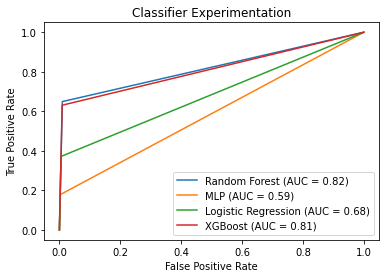

In [60]:
plt.plot(rf_fp, rf_tp, label='Random Forest (AUC = %0.2f)' % rf_auc)
plt.plot(mlp_fp, mlp_tp, label='MLP (AUC = %0.2f)' % mlp_auc)
plt.plot(lr_fp, lr_tp, label='Logistic Regression (AUC = %0.2f)' % lr_auc)
plt.plot(xgb_fp, xgb_tp, label='XGBoost (AUC = %0.2f)' % xgb_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Experimentation')
plt.legend(loc="lower right")
plt.show()

### Feature Analysis

In [103]:
lev_df, lev_class, probabilities = model_eval(features[['SSM', 'MSE']], twisted_df['Registered'], rf_model)
neg = [i[0] for i in probabilities]
pos = [i[1] for i in probabilities]

precision = 0.6281 ±0.0206
recall    = 0.7365 ±0.0095
f1        = 0.6778 ±0.0142
auc        = 0.8604 ±0.0050
[0.02, 0.03, 0.09, 0.29, 0.01, 0.02, 0.01, 0.0, 0.14, 0.9, 0.0, 0.99, 0.97, 0.86, 0.92, 0.95, 0.99, 0.05, 1.0, 0.85, 0.0, 1.0, 1.0, 0.55, 1.0, 0.98, 1.0, 0.0, 0.34, 0.0, 0.03, 0.17, 0.1, 0.08, 0.18, 0.05, 0.06, 0.35, 0.45, 0.1, 0.1, 0.05, 0.1, 0.54, 0.54, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0, 0.98, 1.0, 0.73, 0.97, 0.82, 1.0, 0.93, 0.99, 1.0, 1.0, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.98, 1.0, 1.0, 1.0, 1.0, 0.88, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.82, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.91, 0.84, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 1.0, 1.0, 0.94, 0.97, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.94, 0.88, 0.97, 1.0, 1.0, 1.0, 1.0, 1

In [104]:
lev_df['Registered'] = lev_class.values
lev_df['Negative Prediction'] = neg
lev_df['Positive Prediction'] = pos
lev_df

,SSM,MSE,Registered,Negative Prediction,Positive Prediction
"(googlea.com, google.com)",0.851078,3562.883354,True,0.02,0.98
"(googlej.com, google.com)",0.849594,3890.821388,True,0.03,0.97
"(googlep.com, google.com)",0.850138,3541.100876,True,0.09,0.91
"(googleg.com, google.com)",0.847150,3639.159492,True,0.29,0.71
"(googlel.com, google.com)",0.852116,3855.488113,True,0.01,0.99
...,...,...,...,...,...
"(insqtagram.com, instagram.com)",0.834099,3613.393341,False,0.12,0.88
"(instagr1am.com, instagram.com)",0.831515,3722.531998,False,0.92,0.08
"(instagra2m.com, instagram.com)",0.832508,3693.410309,False,0.49,0.51
"(instawgram.com, instagram.com)",0.827028,4088.740196,False,0.92,0.08


In [105]:
# Create boolean mask based on the conditions
mask = (lev_df['Registered'] & (lev_df['Positive Prediction'] > lev_df['Negative Prediction']))

# Filter the DataFrame based on the mask
filtered_df = lev_df.loc[mask]

# View the filtered DataFrame
filtered_df

,SSM,MSE,Registered,Negative Prediction,Positive Prediction
"(googlea.com, google.com)",0.851078,3562.883354,True,0.02,0.98
"(googlej.com, google.com)",0.849594,3890.821388,True,0.03,0.97
"(googlep.com, google.com)",0.850138,3541.100876,True,0.09,0.91
"(googleg.com, google.com)",0.847150,3639.159492,True,0.29,0.71
"(googlel.com, google.com)",0.852116,3855.488113,True,0.01,0.99
...,...,...,...,...,...
"(istagram.com, instagram.com)",0.852322,3221.088409,True,0.15,0.85
"(iinstagram.com, instagram.com)",0.821251,4741.810089,True,0.17,0.83
"(instagraam.com, instagram.com)",0.834844,3615.047722,True,0.44,0.56
"(jnstagram.com, instagram.com)",0.908763,1257.719048,True,0.10,0.90


In [108]:
sorted_df = filtered_df.sort_values(by='Positive Prediction', ascending=False)
sorted_df

,SSM,MSE,Registered,Negative Prediction,Positive Prediction
"(tw8itter.com, twitter.com)",0.883237,2551.699104,True,0.00,1.00
"(qoogie.com, google.com)",0.992383,122.182693,True,0.00,1.00
"(microsuft.com, microsoft.com)",0.991773,134.152702,True,0.00,1.00
"(facebooc.com, facebook.com)",0.986877,276.975258,True,0.00,1.00
"(twltter.com, twitter.com)",0.998921,23.120117,True,0.00,1.00
...,...,...,...,...,...
"(baid.com, baidu.com)",0.889837,2497.234947,True,0.47,0.53
"(emazonaws.com, amazonaws.com)",0.992621,114.690033,True,0.47,0.53
"(1nstagrarn.com, instagram.com)",0.826988,4502.406700,True,0.48,0.52
"(insvagram.com, instagram.com)",0.823689,4641.342072,True,0.48,0.52


In [135]:
top_homographs = list(sorted_df.index)

In [147]:
import Levenshtein
edits = []
for pair in list(top_homographs):
    output =  (Levenshtein.editops(pair[0], pair[1]))
    for item in output:
        edits.append((item[0], f'{pair[0][item[1]]} in position {item[1]}', f'{pair[1][item[2]]} in position {item[2]}'))
print (edits)


[('delete', '8 in position 2', 'i in position 2'), ('replace', 'q in position 0', 'g in position 0'), ('replace', 'i in position 4', 'l in position 4'), ('replace', 'u in position 6', 'o in position 6'), ('replace', 'c in position 7', 'k in position 7'), ('replace', 'l in position 2', 'i in position 2'), ('delete', 'j in position 3', 't in position 3'), ('replace', 'n in position 4', 'b in position 4'), ('replace', '0 in position 5', 'o in position 5'), ('replace', '0 in position 6', 'o in position 6'), ('delete', 'p in position 1', 'o in position 1'), ('replace', 'n in position 5', 'b in position 5'), ('delete', 'h in position 4', 'l in position 4'), ('replace', 'q in position 3', 'g in position 3'), ('replace', 'n in position 5', 'o in position 5'), ('replace', 'm in position 2', 'o in position 2'), ('replace', '7 in position 2', 'u in position 2'), ('delete', 'l in position 2', 'u in position 2'), ('replace', 'l in position 2', 'i in position 2'), ('replace', 'l in position 0', 'i i

In [148]:
series_edits = pd.Series(edits)
series_edits.value_counts()[:15]

(replace, e in position 0, a in position 0)    3
(replace, l in position 0, i in position 0)    3
(delete, t in position 7, . in position 7)     2
(delete, k in position 2, i in position 2)     2
(replace, e in position 1, a in position 1)    2
(replace, u in position 3, t in position 3)    2
(replace, t in position 2, u in position 2)    2
(replace, z in position 4, u in position 4)    2
(replace, n in position 9, m in position 8)    2
(delete, r in position 8, m in position 8)     2
(delete, 6 in position 7, . in position 7)     2
(delete, 2 in position 7, . in position 7)     2
(delete, o in position 7, . in position 7)     2
(delete, u in position 2, i in position 2)     2
(replace, 0 in position 6, o in position 6)    2
dtype: int64

In [149]:
import Levenshtein
edits = []
for pair in list(top_homographs):
    output =  (Levenshtein.editops(pair[0], pair[1]))
    for item in output:
        edits.append((item[0], pair[0][item[1]], pair[1][item[2]]))

In [150]:
series_edits = pd.Series(edits)
series_edits.value_counts()[:15]

(replace, e, a)    5
(replace, l, i)    5
(replace, 0, o)    5
(replace, n, m)    4
(delete, a, .)     4
(delete, 6, .)     4
(delete, o, .)     4
(replace, i, a)    4
(delete, r, m)     3
(replace, u, t)    3
(delete, l, .)     3
(replace, t, u)    3
(delete, r, .)     3
(delete, l, o)     2
(delete, g, e)     2
dtype: int64